In [3]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import cv2
import keras
from PIL import Image

In [5]:
#directly into memory, load image paths, plus 84 (x,y) keypoints == 168 annotations
#actual images lazy loaded  with Tensorflow Dataset
key_pts_frame = pd.read_csv('/data/training_frames_keypoints.csv')
#reorder so image paths match os.walk order
key_pts_frame = key_pts_frame.sort_values(by='Unnamed: 0')

n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pt_ex = key_pts_frame.iloc[n, 1:].values
key_pt_ex = key_pt_ex.astype('float').reshape(-1, 2)
n_instances = key_pts_frame.shape[0]
print('Number of instances: ', n_instances )
print('\n---Example instance---')
print('Image name: ', image_name)
print('Landmarks shape: ', key_pt_ex.shape)
print('First 4 key pts: {}'.format(key_pt_ex[:4]))

Number of instances:  3462

---Example instance---
Image name:  Abdel_Aziz_Al-Hakim_00.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 65. 109.]
 [ 69. 131.]
 [ 73. 149.]
 [ 82. 162.]]


In [6]:
key_pts = key_pts_frame.iloc[:, 1:].values
print(key_pts.shape)
key_pts = key_pts.reshape(-1,68,2)
print(key_pts.shape)
key_pts_frame.head()

(3462, 136)
(3462, 68, 2)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
2126,Abdel_Aziz_Al-Hakim_00.jpg,65.0,109.0,69.0,131.0,73.0,149.0,82.0,162.0,96.0,...,180.0,155.0,193.0,155.0,180.0,164.0,171.0,164.0,162.0,163.0
2006,Abdel_Aziz_Al-Hakim_01.jpg,74.0,103.0,78.0,125.0,83.0,143.0,91.0,157.0,100.0,...,184.0,149.0,197.0,149.0,184.0,154.0,175.0,158.0,166.0,158.0
1416,Abdel_Aziz_Al-Hakim_02.jpg,79.0,94.0,83.0,112.0,88.0,134.0,97.0,148.0,106.0,...,185.0,140.0,198.0,141.0,190.0,149.0,181.0,149.0,172.0,149.0
3324,Abdel_Aziz_Al-Hakim_10.jpg,65.0,111.0,68.0,123.0,71.0,132.0,74.0,142.0,80.0,...,105.0,139.0,120.0,136.0,105.0,139.0,102.0,142.0,95.0,142.0
2703,Abdel_Aziz_Al-Hakim_11.jpg,89.0,95.0,86.0,107.0,86.0,116.0,86.0,128.0,86.0,...,119.0,129.0,128.0,132.0,116.0,132.0,113.0,132.0,110.0,129.0


In [8]:
#get list of image paths
img_paths = key_pts_frame.iloc[:,0].values
#collect original image size data to stretch label coords at same ratio as stretching images
orig_sizes = np.empty(n_instances,dtype=object)

for i, path in enumerate(img_paths):
    img = Image.open(os.path.join('/data/training_super/training',path))#wont actually bring images into memory
    orig_sizes[i] = img.size

In [10]:
#stretch each label coord to match the stretch of its corresponding image
STD_W = 100
STD_H = 100
STD_SIZE = (STD_W,STD_H)

for i in range(n_instances):
    resize_ratio_W = STD_W/orig_sizes[i][0]
    resize_ratio_H = STD_H/orig_sizes[i][1]
    key_pts[i][:,0] = key_pts[i][:,0]*resize_ratio_W
    key_pts[i][:,1] = key_pts[i][:,1]*resize_ratio_H

train_label_dataset = tf.data.Dataset.from_tensor_slices(key_pts)

In [11]:
#build image dataset

#stretching all images to intermediate size 
BATCH_SIZE = 8
#note that keras requires a super-directory workaround or renaming files if filenames have a certain format
#note drop remainder not available in this method
train_image_dataset = keras.preprocessing.image_dataset_from_directory(
    '/data/training_super/', label_mode=None,
    class_names=None, color_mode='rgb', batch_size=1, image_size=STD_SIZE, shuffle=False, interpolation='bicubic'
) 
train_image_dataset = train_image_dataset.unbatch()
#combine training image and label datasets
train = tf.data.Dataset.zip((train_image_dataset,train_label_dataset))

train = train.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

#20% for validation
#TODO: write helper fxns for this, also loading train and valid from separate dirs
valid = train.enumerate().filter(lambda x, y: x%5==0)
valid= valid.map(lambda x,y:y)

train = train.enumerate().filter(lambda x, y: x%5!=0)
train= train.map(lambda x,y:y)

Found 3462 files belonging to 1 classes.


In [12]:
for x in train.take(1): print('batch input shape',x[0].shape, '\nbatch target shape', x[1].shape)

batch input shape (8, 100, 100, 3) 
batch target shape (8, 68, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


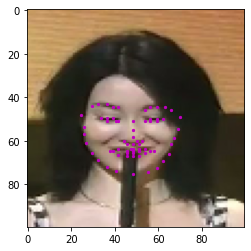

In [13]:
for img, label in train.unbatch().take(1):
    plt.imshow(img/255.)
    plt.scatter(label[:, 0], label[:, 1], s=20, marker='.', c='m')

In [14]:
class ConvBlock(keras.layers.Layer):
    def __init__(self, kernel_size, strides, filters, activation='relu', rate = 0.2,padding='SAME', **kwargs):
        super().__init__(**kwargs)

        self.activation = keras.activations.get(activation)

        self.layers = [
                keras.layers.Conv2D(kernel_size=kernel_size, strides=strides, filters=filters, activation = None, padding= padding),
                keras.layers.BatchNormalization(),
                self.activation,
                keras.layers.Dropout(rate)
        ]


    def call(self, inputs):
        Z = inputs
        for layer in self.layers:
            Z = layer(Z)
        return Z

In [15]:
class AvgPoolBlock(keras.layers.Layer):
    def __init__(self, pool_size, strides, padding='VALID',rate = 0.2, **kwargs):
        super().__init__(**kwargs)

        self.layers = [
                keras.layers.AveragePooling2D(pool_size=pool_size, strides=strides,padding= padding),
                keras.layers.BatchNormalization(),
                keras.layers.Dropout(rate)
        ]

    def call(self, inputs):
        Z = inputs
        for layer in self.layers:
            Z = layer(Z)
        return Z

In [16]:
class MaxPoolBlock(keras.layers.Layer):
    def __init__(self, pool_size, strides, padding='VALID',rate = 0.2, **kwargs):
        super().__init__(**kwargs)

        self.layers = [
                keras.layers.MaxPooling2D(pool_size=pool_size, strides=strides,padding= padding),
                keras.layers.BatchNormalization(),
                keras.layers.Dropout(rate)
        ]

    def call(self, inputs):
        Z = inputs
        for layer in self.layers:
            Z = layer(Z)
        return Z

In [17]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)
#TODO *** RUN INSIDE CUSTOM TRAIN FXN***
# with tf.device("/cpu:0"): # there is no GPU-kernel yet
#     Z = DepthMaxPool(DEPTH_POOL_SIZE)(Z)

In [23]:
DEPTH_POOL_SIZE = 2
CONTRAST_FACTOR = (.5,.5)
BRIGHTNESS_RANGE = (1,10)
INTENSITY_FACTOR = 10

I = keras.layers.Input(shape=[None, None,3])

Z = tf.keras.layers.experimental.preprocessing.Resizing(height=STD_H, width=STD_W, interpolation="bilinear")(I) 
Z = tf.keras.layers.experimental.preprocessing.RandomContrast(CONTRAST_FACTOR)(Z)
#TODO: MORE RANDOM AUGMENTATIONS- SHIFTING, BRIGHTNESS, ROTATION, ZOOM, ETC.

keras.layers.Conv2D(kernel_size=[1,1,1,3], strides=[1,1,1,3])#depth pool the channels
Z = ConvBlock(kernel_size=5, strides=2,filters=64, rate = 0)(Z)
Z = ConvBlock(kernel_size=3, strides=1,filters=64, rate = 0)(Z)
Z = MaxPoolBlock(pool_size=3, strides=2, rate = 0)(Z)
Z = ConvBlock(kernel_size=3, strides=1,filters=64, rate = 0)(Z)
Z = ConvBlock(kernel_size=3, strides=1,filters=64, rate = 0)(Z)
Z = MaxPoolBlock(pool_size=3, strides=2, rate = 0)(Z)
Z = ConvBlock(kernel_size=3, strides=1,filters=136*DEPTH_POOL_SIZE, rate = 0.5)(Z)
Z = ConvBlock(kernel_size=3, strides=1,filters=136*DEPTH_POOL_SIZE, rate = 0.5)(Z)
Z = ConvBlock(kernel_size=3, strides=1,filters=136*DEPTH_POOL_SIZE, rate = 0)(Z) 

#depth pool filters/channels dim to get 136 output filters
keras.layers.Conv2D(kernel_size=[1,1,1,DEPTH_POOL_SIZE], strides=[1,1,1,DEPTH_POOL_SIZE])

#reduce each input feature map to single point--> 1 output value per input filter
Z = keras.layers.GlobalAveragePooling2D()(Z)

Z = keras.layers.Reshape(target_shape=[68,2])(Z)

model = keras.models.Model(inputs =I, outputs = Z)

optimizer = keras.optimizers.Nadam(lr=0.2)
model.compile(loss='mse', optimizer=optimizer)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
resizing_1 (Resizing)        (None, 100, 100, 3)       0         
_________________________________________________________________
random_contrast_1 (RandomCon (None, 100, 100, 3)       0         
_________________________________________________________________
conv_block_6 (ConvBlock)     (None, 50, 50, 64)        5120      
_________________________________________________________________
conv_block_7 (ConvBlock)     (None, 50, 50, 64)        37184     
_________________________________________________________________
max_pool_block_2 (MaxPoolBlo (None, 24, 24, 64)        256       
_________________________________________________________________
conv_block_8 (ConvBlock)     (None, 24, 24, 64)        3718

In [24]:
root_logdir = os.path.join(os.curdir, "keypoint_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
print('run logged at:' ,run_logdir)

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
checkpoint_cb = keras.callbacks.ModelCheckpoint('keypoint_model', save_best_only=True)
early_stop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(train,epochs=20,validation_data=valid, callbacks=[tensorboard_cb, checkpoint_cb,early_stop_cb])

run logged at: ./keypoint_logs/run_2021_01_20-17_19_20
Epoch 1/20
345/345 [==============================] - 70s 174ms/step - loss: 1514.9798 - val_loss: 66.3683
INFO:tensorflow:Assets written to: keypoint_model/assets
INFO:tensorflow:Assets written to: keypoint_model/assets
Epoch 2/20
345/345 [==============================] - 68s 175ms/step - loss: 47.9378 - val_loss: 38.2747
INFO:tensorflow:Assets written to: keypoint_model/assets
INFO:tensorflow:Assets written to: keypoint_model/assets
Epoch 3/20
345/345 [==============================] - 65s 168ms/step - loss: 29.4819 - val_loss: 64.2661
Epoch 4/20
345/345 [==============================] - 63s 163ms/step - loss: 27.7764 - val_loss: 32.1792
INFO:tensorflow:Assets written to: keypoint_model/assets
INFO:tensorflow:Assets written to: keypoint_model/assets
Epoch 5/20
345/345 [==============================] - 64s 166ms/step - loss: 26.9272 - val_loss: 27.8480
INFO:tensorflow:Assets written to: keypoint_model/assets
INFO:tensorflow:Ass

KeyboardInterrupt: 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./keypoint_logs --port=9999

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
resizing_1 (Resizing)        (None, 100, 100, 3)       0         
_________________________________________________________________
random_contrast_1 (RandomCon (None, 100, 100, 3)       0         
_________________________________________________________________
conv_block_6 (ConvBlock)     (None, 50, 50, 64)        5120      
_________________________________________________________________
conv_block_7 (ConvBlock)     (None, 50, 50, 64)        37184     
_________________________________________________________________
max_pool_block_2 (MaxPoolBlo (None, 24, 24, 64)        256       
_________________________________________________________________
conv_block_8 (ConvBlock)     (None, 24, 24, 64)        3718

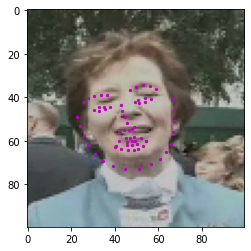

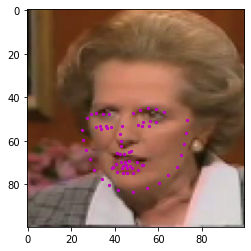

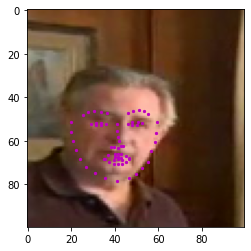

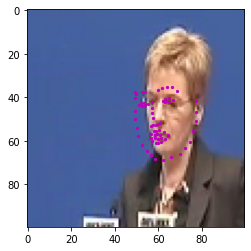

In [81]:
#DISPLAY A SAMPLE OF THE PREDICTIONS
target_images = [ x for x in valid.map(lambda x, y : x).take(1).unbatch()
target = tf.data.Dataset.from_tensor_slices(target_images).batch(8)]
preds = model.predict(target)
ixs = [0,4,6,7]
for ix in ixs:
    pred = preds[ix]
    img = target_images[ix]
    plt.imshow(img/255.)
    plt.scatter(pred[:, 0], pred[:, 1], s=20, marker='.', c='m')
    plt.show()